In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

np.random.seed(0)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score

import logging

logging.basicConfig(level=logging.WARN)


<IPython.core.display.Javascript object>

In [3]:
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.layers import (
    Conv1D,
    SpatialDropout1D,
    LocallyConnected1D,
    Dense,
    Reshape,
    MaxPooling1D,
    BatchNormalization,
    Activation,
    LayerNormalization,
    Concatenate
)

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow_addons.activations import mish
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
from tensorflow_addons.layers import WeightNormalization

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder


from itertools import repeat
from concurrent.futures import ProcessPoolExecutor as PoolExecutor

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline


<IPython.core.display.Javascript object>

In [4]:
import tensorflow_addons as tfa

<IPython.core.display.Javascript object>

In [5]:
def word_to_np_array(word, cut_length):
    result = np.zeros(cut_length, dtype="uint8")
    for i, letter in enumerate(word[:cut_length]):
        result[i] = ord(letter)
    return result

<IPython.core.display.Javascript object>

In [6]:
def line_to_img(line, cut_length):
    result = np.zeros((line.shape[0], cut_length), dtype="uint8")
    for i in range(line.shape[0]):
        result[i] = word_to_np_array(line[i], cut_length)
    return result

<IPython.core.display.Javascript object>

In [7]:
def do_parallel_numpy(map_func, iter_params, constant_params=None):
    repeated_params = (
        [] if constant_params is None else list(map(repeat, constant_params))
    )
    results = None
    with PoolExecutor() as executor:
        results = np.stack(
            list(executor.map(map_func, *iter_params, *repeated_params)), axis=0
        )
    return results

<IPython.core.display.Javascript object>

In [8]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [9]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

In [10]:
dataset_name = "bank-marketing"
filename = "train_bench.csv"
target = "y"
ids = []

<IPython.core.display.Javascript object>

dataset_name = "rl"
filename = "train_bench.csv"
target = "target"
ids = []

dataset_name = "open-payments"
filename = "train_bench.csv"
target = "status"
ids = []

dataset_name = "give-me-some-credit"
filename = "train_bench.csv"
target = "SeriousDlqin2yrs"
ids = ["Unamed"]

dataset_name = "santander-customer-satisfaction"
filename = "train_bench.csv"
target = "TARGET"
ids = []

In [11]:
out = Path(os.getcwd()) / "data" / dataset_name / filename

<IPython.core.display.Javascript object>

In [12]:
train = pd.read_csv(out)
train.shape

(41188, 21)

<IPython.core.display.Javascript object>

In [13]:
constant_cols = train.columns[train.nunique() <= 1]
constant_cols

Index([], dtype='object')

<IPython.core.display.Javascript object>

In [14]:
n_unique = train.nunique()

<IPython.core.display.Javascript object>

In [15]:
bool_cols = train.columns[n_unique == 2]
bool_cols = list(set(bool_cols.tolist()) - set([target]) - set(["Set"]))
bool_cols

['contact']

<IPython.core.display.Javascript object>

In [16]:
bool_encoder = {}

<IPython.core.display.Javascript object>

In [17]:
for col in bool_cols:
    enc = LabelEncoder()
    train[col] = enc.fit_transform(train[col].values.astype("str").reshape(-1))
    bool_encoder[col] = enc

<IPython.core.display.Javascript object>

In [18]:
constant_cols = train.columns[n_unique <= 1]
constant_cols = list(set(constant_cols.tolist()) - set([target]) - set(["Set"]))
constant_cols

[]

<IPython.core.display.Javascript object>

In [19]:
ratio = 0.05  #  This means we consider this a category if 1000 elt, there is at most 50 different values

<IPython.core.display.Javascript object>

In [20]:
cat_cols = train.columns[
    (
        (train.dtypes == "object")
        | ((n_unique > 2) & (((n_unique / train.shape[0]) < ratio)))
    )
]
cat_cols = list(set(cat_cols.tolist()) - set([target]) - set(["Set"]))
cat_cols

['euribor3m',
 'cons_price_idx',
 'job',
 'marital',
 'emp_var_rate',
 'education',
 'loan',
 'month',
 'pdays',
 'age',
 'poutcome',
 'previous',
 'nr_employed',
 'default',
 'day_of_week',
 'housing',
 'campaign',
 'cons_conf_idx']

<IPython.core.display.Javascript object>

In [21]:
other_cols = train.columns[
    (n_unique > 2) & (train.dtypes != "object") & ((n_unique / train.shape[0]) >= ratio)
]
other_cols = list(set(other_cols.tolist()) - set([target]) - set(["Set"]))
other_cols

[]

<IPython.core.display.Javascript object>

In [22]:
target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [23]:
train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))

<IPython.core.display.Javascript object>

In [24]:
used_columns = list(
    set(train.columns.tolist())
    - set([target])
    - set(["Set"])
    - set(ids)
    - set(bool_cols)
    - set(constant_cols)
    - set(other_cols)
)
used_columns

['euribor3m',
 'cons_price_idx',
 'job',
 'marital',
 'emp_var_rate',
 'education',
 'loan',
 'month',
 'pdays',
 'age',
 'poutcome',
 'previous',
 'nr_employed',
 'default',
 'day_of_week',
 'housing',
 'campaign',
 'cons_conf_idx']

<IPython.core.display.Javascript object>

In [25]:
bool_cols

['contact']

<IPython.core.display.Javascript object>

In [26]:
other_cols

[]

<IPython.core.display.Javascript object>

In [27]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index


<IPython.core.display.Javascript object>

In [28]:
train[other_cols] = train[other_cols].fillna(
    train[other_cols].min() - train[other_cols].std() / 10
)

<IPython.core.display.Javascript object>

scaler = StandardScaler()
scaler.fit(train[other_cols].values[train_indices])
train[other_cols] = scaler.transform(train[other_cols])

In [29]:
# train["Set"] = np.random.choice(
#     ["train", "valid"], p=[0.8, 0.2], size=(train.shape[0],)
# )
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

X_train = np.char.strip(train[used_columns].values[train_indices].astype("str"))
X_valid = np.char.strip(train[used_columns].values[valid_indices].astype("str"))
X_test = np.char.strip(train[used_columns].values[test_indices].astype("str"))

X_bool_train = train[bool_cols].values[train_indices]
X_bool_valid = train[bool_cols].values[valid_indices]
X_bool_test = train[bool_cols].values[test_indices]

X_num_train = train[other_cols].values[train_indices]
X_num_valid = train[other_cols].values[valid_indices]
X_num_test = train[other_cols].values[test_indices]

y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]
y_test = train[target].values[test_indices]

<IPython.core.display.Javascript object>

In [30]:
del train, train_indices, valid_indices, test_indices

<IPython.core.display.Javascript object>

In [31]:
X_train.shape

(32950, 18)

<IPython.core.display.Javascript object>

In [32]:
INPUT_DIM = X_train.shape[1]
INPUT_DIM_BOOL = X_bool_train.shape[1]
INPUT_DIM_NUM = X_num_train.shape[1]

if X_train.shape[1] > 0:
    NB_CHANNELS = np.vectorize(len)(X_train).max()
else:
    NB_CHANNELS = 0
NB_CHANNELS

19

<IPython.core.display.Javascript object>

In [33]:
X_train_preproc = do_parallel_numpy(line_to_img, [X_train], [NB_CHANNELS])
X_valid_preproc = do_parallel_numpy(line_to_img, [X_valid], [NB_CHANNELS])
X_test_preproc = do_parallel_numpy(line_to_img, [X_test], [NB_CHANNELS])

<IPython.core.display.Javascript object>

In [34]:
# Y_train_preproc = to_categorical(y_train)
# Y_valid_preproc = to_categorical(y_valid)
# Y_test_preproc = to_categorical(y_test)

<IPython.core.display.Javascript object>

In [35]:
def build_model(
    input_dim_cat,
    input_dim_bool,
    input_dim_num,
    nb_channels,
    conv_dim=[],
    lconv_dim=[],
    lconv_num_dim=[],
):
    activation = mish
    optimizer = Lookahead(RectifiedAdam(1e-3), sync_period=6, slow_step_size=0.5)

    inputs = []
    concats = []

    if input_dim_bool > 0:
        input_bool_layer = Input(shape=(input_dim_bool,), name="input_bool")
        inputs.append(input_bool_layer)
        concats.append(input_bool_layer)

    if input_dim_num > 0:
        input_num_layer = Input(shape=(input_dim_num,), name="input_num")
        inputs.append(input_num_layer)
        x_num_layer = Reshape((input_dim_num, 1), name="reshape_num_input")(
            input_num_layer
        )

        for i, lconv_layer in enumerate(lconv_num_dim):
            name = f"block_lconv_num_{i}_"
            x_num_layer = LocallyConnected1D(
                filters=lconv_layer,
                padding="valid",
                kernel_size=1,
                strides=1,
                name=name + "conv",
                use_bias=False,
                activation=None,
            )(x_num_layer)
            x_num_layer = BatchNormalization(name=name + "nb")(x_num_layer)
            x_num_layer = Activation(activation, name=name + "activation")(x_num_layer)
        nb_filters = lconv_num_dim[-1] if len(lconv_dim) > 0 else conv_dim[-1]
        x_num_layer = Reshape((input_dim_num * nb_filters,), name="reshape_num_output")(
            x_num_layer
        )
        concats.append(x_num_layer)

    if input_dim_cat > 0:
        input_cat_layer = Input(shape=(input_dim_cat, nb_channels), name="input_cat")
        inputs.append(input_cat_layer)

        x_layer = input_cat_layer
        for i, conv_layer in enumerate(conv_dim):
            name = f"block_conv_{i}_"
            x_layer = Conv1D(
                filters=conv_layer,
                padding="valid",
                kernel_size=1,
                strides=1,
                name=name + "conv",
                use_bias=False,
                activation=None,
            )(x_layer)
            x_layer = BatchNormalization(name=name + "nb")(x_layer)
            x_layer = Activation(activation, name=name + "activation")(x_layer)

        for i, lconv_layer in enumerate(lconv_dim):
            name = f"block_lconv_{i}_"
            x_layer = LocallyConnected1D(
                filters=lconv_layer,
                padding="valid",
                kernel_size=1,
                strides=1,
                name=name + "lconv",
                use_bias=False,
                activation=None,
            )(x_layer)
            x_layer = BatchNormalization(name=name + "nb")(x_layer)
            x_layer = Activation(activation, name=name + "activation")(x_layer)
        nb_filters = lconv_dim[-1] if len(lconv_dim) > 0 else conv_dim[-1]
        x_layer = Reshape((input_dim_cat * nb_filters,), name="reshape")(x_layer)
        concats.append(x_layer)

    if len(concats) > 1:
        concat = Concatenate()(concats)
    else:
        concat = concats[0]

    output = Dense(1, activation="sigmoid", name="output")(concat)

    model = Model(inputs=inputs, outputs=[output], name="first_model",)
    model.compile(loss="binary_crossentropy", optimizer=optimizer)

    return model

<IPython.core.display.Javascript object>

In [36]:
model = build_model(
    INPUT_DIM,
    INPUT_DIM_BOOL,
    INPUT_DIM_NUM,
    NB_CHANNELS,
    conv_dim=[],
    lconv_dim=[128, 64, 32],
    lconv_num_dim=[64, 32, 16],
)

<IPython.core.display.Javascript object>

In [37]:
model.summary()

Model: "first_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cat (InputLayer)          [(None, 18, 19)]     0                                            
__________________________________________________________________________________________________
block_lconv_0_lconv (LocallyCon (None, 18, 128)      43776       input_cat[0][0]                  
__________________________________________________________________________________________________
block_lconv_0_nb (BatchNormaliz (None, 18, 128)      512         block_lconv_0_lconv[0][0]        
__________________________________________________________________________________________________
block_lconv_0_activation (Activ (None, 18, 128)      0           block_lconv_0_nb[0][0]           
________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [38]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

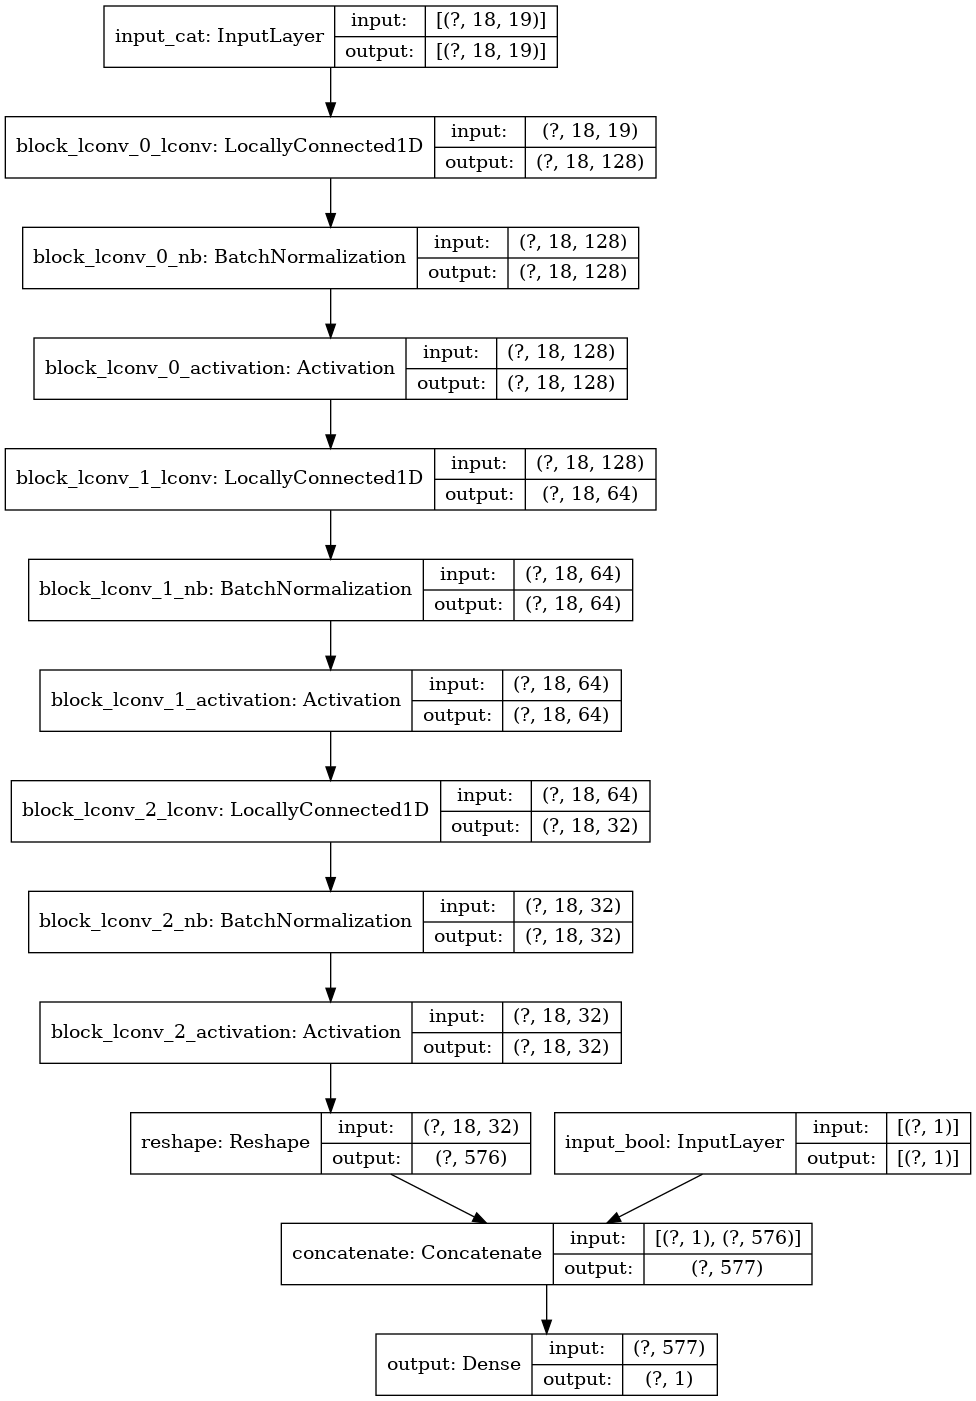

<IPython.core.display.Javascript object>

In [39]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [40]:
y_train.shape

(32950,)

<IPython.core.display.Javascript object>

In [41]:
input_model = []
input_valid = []
input_test = []

<IPython.core.display.Javascript object>

In [42]:
if INPUT_DIM_BOOL > 0:
    input_model.append(X_bool_train)
    input_valid.append(X_bool_valid)
    input_test.append(X_bool_test)
if INPUT_DIM_NUM > 0:
    input_model.append(X_num_train)
    input_valid.append(X_num_valid)
    input_test.append(X_num_test)
if INPUT_DIM > 0:
    input_model.append(X_train_preproc)
    input_valid.append(X_valid_preproc)
    input_test.append(X_test_preproc)

<IPython.core.display.Javascript object>

In [43]:
%%time
history = model.fit(
    tuple(input_model),
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(tuple(input_valid), y_valid.reshape(-1, 1),),
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=50, verbose=1)],
)

Epoch 1/2000


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


33/33 [==============================] - 15s 448ms/step - loss: 0.3454 - val_loss: 0.6361
Epoch 2/2000
33/33 [==============================] - 14s 412ms/step - loss: 0.3141 - val_loss: 0.6346
Epoch 3/2000
33/33 [==============================] - 15s 464ms/step - loss: 0.2951 - val_loss: 0.6198
Epoch 4/2000
33/33 [==============================] - 16s 485ms/step - loss: 0.2885 - val_loss: 0.5918
Epoch 5/2000
33/33 [==============================] - 14s 424ms/step - loss: 0.2881 - val_loss: 0.5847
Epoch 6/2000
33/33 [==============================] - 14s 420ms/step - loss: 0.2869 - val_loss: 0.5580
Epoch 7/2000
33/33 [==============================] - 15s 453ms/step - loss: 0.2882 - val_loss: 0.4724
Epoch 8/2000
33/33 [==============================] - 14s 420ms/step - loss: 0.2864 - val_loss: 0.4667
Epoch 9/2000
33/33 [==============================] - 14s 413ms/step - loss: 0.2853 - val_loss: 0.4109
Epoch 10/2000
20/33 [=================>............] - ETA: 5s - loss: 0.2767

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [44]:
plot_history(history)

NameError: name 'history' is not defined

<IPython.core.display.Javascript object>

In [ ]:
model_auc = roc_auc_score(
    y_true=y_valid, y_score=model.predict(input_valid).reshape(-1),
)
model_auc

In [ ]:
model_auc = roc_auc_score(y_true=y_test, y_score=model.predict(input_test).reshape(-1),)
model_auc

In [ ]:
# NEW VERSION
# Bank marketing
# valid 0.7974101623084582 test 0.8133980360868731     conv_dim=[],    lconv_dim=[128, 64, 32],    lconv_num_dim=[64, 32, 16], patience 20

In [ ]:
# Census example
# valid 0.9282381974389771 test 0.9262939626480025 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

# RL
# valid 0.9363136991351992 test 0.9431532242454923 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

# Open payments
# valid 0.9395366568006073 test 0.9370193221838594 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

# give-me-some-credit
# valid  test  conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

In [ ]:
SAMPLE_NB = 1000

In [ ]:
sample = X_valid_preproc[:SAMPLE_NB]
bool_sample = X_bool_valid[:SAMPLE_NB]
num_sample = X_num_valid[:SAMPLE_NB]

In [ ]:
model_pred = model.predict((bool_sample, num_sample, sample))
model_pred.shape

In [ ]:
model.layers[-6].output

In [ ]:
model.layers[-7].output

In [ ]:
new_model = Model(
    inputs=[model.inputs],
    outputs=[model.output, model.layers[-6].output, model.layers[-7].output],
)

In [ ]:
new_model_pred, feature_cat_inter, feature_num_inter = new_model.predict(
    (bool_sample, num_sample, sample)
)

In [ ]:
assert np.all(model_pred == new_model_pred)

In [ ]:
feature_cat_inter.shape

In [ ]:
feature_num_inter.shape

In [ ]:
sample.shape

In [ ]:
feature_inter.shape

In [ ]:
num_sample_zero = np.zeros(num_sample.shape)
bool_sample_zero = np.zeros(bool_sample.shape)

for idx in range(sample.shape[1]):
    real_idx = bool_sample.shape[1] + num_sample.shape[1] + idx
    sample_one_col = np.zeros(sample.shape)

    sample_one_col[:, idx] = sample[:, idx]
    _, feature_inter_one_col, _ = new_model.predict(
        (bool_sample_zero, num_sample_zero, sample_one_col)
    )
    #     for elt in range(feature_inter_one_col.shape[2]):
    #         print(elt)
    #         print(feature_inter_one_col[:, idx, :][elt])
    #         print(feature_cat_inter[:, idx, :][elt])
    #     print(np.sum(feature_inter_one_col[:, idx, :] - feature_cat_inter[:, idx, :]))
    assert np.all(feature_inter_one_col[:, idx, :] == feature_cat_inter[:, idx, :])
#     assert np.sum(feature_inter_one_col - feature_cat_inter) > 1

In [ ]:
idx = 0
real_idx = bool_sample.shape[1] + num_sample.shape[1] + idx
sample_one_col = np.zeros(sample.shape)

sample_one_col[:, idx] = sample[:, idx]
_, feature_inter_one_col, _ = new_model.predict(
    (bool_sample_zero, num_sample_zero, sample_one_col)
)
assert np.all(feature_inter_one_col[:, idx, :] == feature_cat_inter[:, idx, :])

In [ ]:
feature_inter_one_col[:, 0, :].shape

In [ ]:
new_model.layers[-1]

In [ ]:
model.get_weights()[-2].shape

In [ ]:
model.layers[-2].output

In [ ]:
new_model = Model(inputs=[model.input], outputs=[model.layers[-2].output])

In [ ]:
%%time
new_train_logistic = new_model.predict((X_bool_train, X_num_train, X_train_preproc))
new_valid_logistic = new_model.predict((X_bool_valid, X_num_valid, X_valid_preproc))
new_test_logistic = new_model.predict((X_bool_test, X_num_test, X_test_preproc))

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
lreg = LogisticRegression(max_iter=300, n_jobs=-1)

In [ ]:
%%time
lreg.fit(new_train_logistic, y_train.reshape(-1))

In [ ]:
roc_auc_score(
    y_true=y_valid, y_score=lreg.predict_proba(new_valid_logistic)[:, 1],
)

In [ ]:
roc_auc_score(
    y_true=y_test, y_score=lreg.predict_proba(new_test_logistic)[:, 1],
)

In [ ]:
lreg_cv = LogisticRegressionCV(Cs=10, max_iter=300, n_jobs=-1, cv=5, random_state=0)

In [ ]:
%%time
lreg_cv.fit(new_train_logistic, y_train.reshape(-1))

In [ ]:
roc_auc_score(
    y_true=y_valid, y_score=lreg_cv.predict_proba(new_valid_logistic)[:, 1],
)

In [ ]:
roc_auc_score(
    y_true=y_test, y_score=lreg_cv.predict_proba(new_test_logistic)[:, 1],
)